# Dragging gestures: Analysis

In [69]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt

In [103]:
df = pd.read_csv('logs.csv')

print("Columns:", df.columns)
# indices of important columns
prAgeInd = 1
deviceInd = 2
testModeInd = 3
funcIdInd = 5
funcDiffInd = 6
funcProjInd = 7
drawTimeInd = 8

test0data = df[df['Test mode'] == 0]
test1data = df[df['Test mode'] == 1]

projections = ['Cartesian', 'Polar']
funcIds = [0, 1, 2, 3, 4, 5]
devices = ['Mouse', 'Graphic tablet']
testModes = [0, 1]

Columns: Index(['Participant name', 'Participant age', 'Device', 'Test mode',
       'Logging timestamp', 'Function ID', 'Function difficulty',
       'Function projection', 'Drawing time', 'Error approx', 'Is Left handed',
       'Experienced Graphic Tablet User'],
      dtype='object')


## Participant data

Number of participants: 9
Average participant age: 23.111

 ::::
Number of left handed participants: 1
Percentage of left handed participants 0.111 %

 ::::
Number of expert graphic tablet participants: 2
Percentage of expert graphic tablet participants 0.222 %


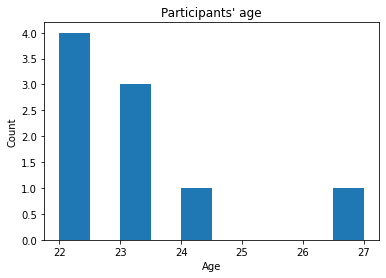

In [74]:
participants = list(set(test0data['Participant name']))

print("Number of participants:", len(participants))

ages = []
leftHanded = 0
hasExpWTablet = 0
for participant in participants:
    row = df[df['Participant name'] == participant]
    age = row['Participant age'].values[0]
    leftHanded += row['Is Left handed'].values[0]
    hasExpWTablet += row['Experienced Graphic Tablet User'].values[0]
    # print(participant, age)
    ages.append(age)

plt.figure()
plt.hist(ages)
plt.ylabel("Count")
plt.xlabel("Age")
plt.title("Participants' age")
plt.plot
print("Average participant age:", round(np.mean(ages), 3))

print("\n ::::")
print("Number of left handed participants:", leftHanded)
print("Percentage of left handed participants", round(leftHanded * 1.0 / len(participants), 3), '%')

print("\n ::::")
print("Number of expert graphic tablet participants:", hasExpWTablet)
print("Percentage of expert graphic tablet participants",
      round(hasExpWTablet * 1.0 / len(participants), 3), '%'
    )


# Average drawing time for each curve on each input device

In [108]:
def getAvgForFunc(projection, funcId, device, test = 0):
    # filter out by projection, Cartesian or Polar
    drawingTimes = df[df['Function projection'] == projection]
    # filter out by function ID
    drawingTimes = drawingTimes[drawingTimes['Function ID'] == funcId]
    # filter out test
    drawingTimes = drawingTimes[drawingTimes['Test mode'] == test]
    # filter out by device
    drawingTimes = drawingTimes[drawingTimes['Device'] == device]
    drawingTimes = drawingTimes['Drawing time'].values
    
    dtSum = 0.0
    
    for dt in drawingTimes:
        dtSum += dt
    
    avg = dtSum * 1.0 / len(drawingTimes)
    
    return avg

for mode in testModes:
    print("----------------- MODE:", mode)
    for device in devices:
        print(":::", device, ":::")
        for funcId in funcIds:
            print("--> Function: ", funcId)
            for projection in projections:
                avg = getAvgForFunc(projection, funcId, device, mode)
                print("\t", projection, ": ", avg)
            print()

----------------- MODE: 0
::: Mouse :::
--> Function:  0
	 Cartesian :  7.1814574666111115
	 Polar :  19.391459081388888

--> Function:  1
	 Cartesian :  12.435337980555554
	 Polar :  20.108133925555553

--> Function:  2
	 Cartesian :  27.137250238333333
	 Polar :  20.934750820500003

--> Function:  3
	 Cartesian :  32.89476863444444
	 Polar :  25.094222718333338

--> Function:  4
	 Cartesian :  34.909072464999994
	 Polar :  36.12482166277778

--> Function:  5
	 Cartesian :  39.94069378888889
	 Polar :  34.14002531166667

::: Graphic tablet :::
--> Function:  0
	 Cartesian :  8.1507682935
	 Polar :  21.083509617055554

--> Function:  1
	 Cartesian :  14.871144560277779
	 Polar :  23.20204076444444

--> Function:  2
	 Cartesian :  32.821063253333335
	 Polar :  21.430832320555556

--> Function:  3
	 Cartesian :  33.56397346666667
	 Polar :  25.050273642777782

--> Function:  4
	 Cartesian :  38.68129673388889
	 Polar :  39.00965787277778

--> Function:  5
	 Cartesian :  45.44844063166666